#### 本次成绩:85

### 评卷标准:
- 分析，理顺，项目要求并落实在文档中   不够完善，项目步骤都正常进行。但欠缺说明，
- 比较不同结果 ，思考，改进，总结。   不够完善，对于不同的结果，没有太多总结，而是直接换别的方法。
- 成绩提交并截图成绩   √
- 最终结论，报告。    有，但仍需要再仔细 完成。

总体看到技术该体现的都是体现，但缺乏分段。因为这个是一个比赛项目的综合性的报告，面向的是你的面试官，而非单纯的技术方案。

#### 评卷：David

In [1]:
# 先导一些基本的包
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
import numpy as np
import seaborn as sns

# 房价预测 House Price Prediction


引用
(https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

**kaggle 表现**
- Kaggle 名字: Zhao xingchen
- Kaggle 最好成绩:  0.11444
- Kaggle 最好排名: 116

**本地表现**

本地跑得结果(RMSE)低于0.10,但提交过后得成绩并没有这么好,说明在数据上出现过拟合

**final delivery notes**

kaggle 比赛链接https://www.kaggle.com/c/house-prices-advanced-regression-techniques.

流程结构如下:

1. 数据清洗和预处理 Data Cleaning and Pre-processing
    - 离群(异常)值 Outliers
    - 数据转换 Statistical transformations
2. 特征工程 Feature Engineering
    - 联结 Concatenation
    - 空值 NA's
    - 不正确值 Incorrect values
    - 特征类型转化 Factorization
    - 进一步数值转化 Further Statistical transformation
    - 删除列 Column removal
    - 构造特征 Creating features
    - 哑变量 Dummies
    - 进一步研究异常值 In-depth outlier detection
    - 预防过拟合 Overfit prevention
    - 基准模型 Baseline model
3. 特征选择 Feature Selection
    - 过滤方法 Filter methods
        - 基准系数 baseline coefficients
    - 内嵌模型 Embedded methods
        - 岭回归 L2: Ridge Regression
        - 套索回归 L1: Lasso regression
            -  进一步系数分析 In-depth coefficient analysis
        - 弹性网 Elastic net
        - XGBoost
        - SVR
        - LightGBM
3. 融合方法 Ensemble methods
    - 堆积泛化 Stacked generalizations
    - 平均化 Averaging
        - 标准差 standard
        - 权重 weighted
4. 预测 Prediction


除了上述提到的,还有用到GridsearchCV。 网格搜索帮助找到了可以接着用的Alpha和L1范围。 但是，在特征工程的每次迭代中不断地对最优参数进行网格划分是不可行的,所以省略了.

**特征工程feature engineering tries**
- 在数据有序的情况下,对类别重新编码来保持有序的信息
- 对时间变量做处理 
- 对通过以saleprice排序后的领域变量进行简化 
- 简化变量


如果说一半时间在做特征选择和特征工程,另一半时间就在混合和优化模型.

最后，我觉得以下几件事情, 对结果有不小的影响,异常值删除，细微的NA填充和平均叠加泛化模型。

In [2]:
#读取数据 Data reading

train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


# 1. 数据清洗和预处理Data Cleaning and Pre-processing
## 离群值Outliers
根据数据集的文档（http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt），存在异常值，建议删除。 绘制SalePrice与GR LIV AREA图可直观查看。

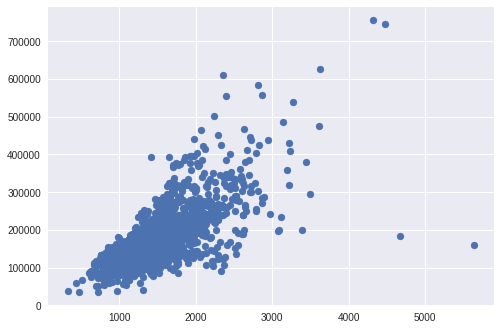

In [4]:
plt.scatter(train.GrLivArea, train.SalePrice)

离群值很明显,即GrlivArea大于4000平方英尺的数据,多次训练发现移除GrlivArea大于4500平方英尺的数据效果更好

In [1]:
train = train[train.GrLivArea < 4500]
plt.scatter(train.GrLivArea, train.SalePrice)

NameError: name 'train' is not defined

In [6]:
# 验证数据量是否相等
print(len(np.unique(train['Id'])) == len(train))
len(np.unique(test['Id'])) == len(test)

True


True

In [7]:
len(train)

1458

丢掉 'Id' 列.

In [8]:
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

In [9]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1458, 80)
Test set size: (1459, 79)


## 数据转化Statistical transformation
查看目标变量的分布

In [10]:
df = pd.concat([train.SalePrice, np.log(train.SalePrice + 1).rename('LogSalePrice')], axis=1, names=['SalePrice', 'LogSalePrice'])
df.head()

,SalePrice,LogSalePrice
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


Text(0.5,0,'Log SalePrice')

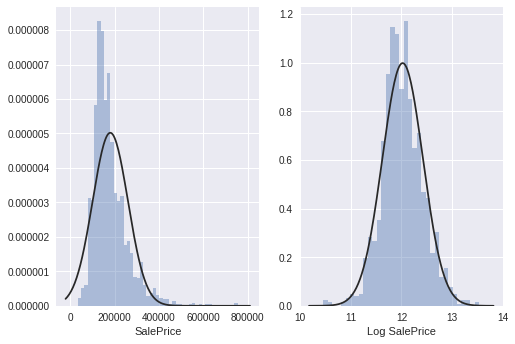

In [11]:
plt.subplot(1, 2, 1)
sns.distplot(train.SalePrice, kde=False, fit = norm)

plt.subplot(1, 2, 2)
sns.distplot(np.log(train.SalePrice + 1), kde=False, fit = norm)
plt.xlabel('Log SalePrice')

目标变量有明显的右偏,可以通过log函数变化来纠正


In [12]:
train.SalePrice = np.log1p(train.SalePrice)

# 2. 特征工程Feature Engineering
## 联结Concatenation
为了保持测试和训练特征之间的一致性，可以在记住索引的同时连接两个集合，以便我们可以在以后再分割它。

In [13]:
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [14]:
print(train_features.shape)
print(test_features.shape)

(1458, 79)
(1459, 79)


In [15]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
features.shape

(2917, 79)

## 空值NA's
找到对空值进行按类别分类,并进行评估

In [16]:
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                 0        1
PoolQC        2908   object
MiscFeature   2812   object
Alley         2719   object
Fence         2346   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageYrBlt    159  float64
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
Functional       2   object
Utilities        2   object
GarageArea       1  float64
GarageCars       1  float64
Electrical       1   object
KitchenQual      1   object
TotalBsmtSF      1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Exterior2nd      1   object
Exterior1st      1   object
SaleType         1   object
There are 34 columns

大多数空值可以填充None,除此之外还可以通过以下预测:Most of these can be filled with 'None'. Some exceptions though:

- 功能性Functional: 文档里有提及用"Typ"
- 电气Electrical: 文档里虽然没有提及,但是必需的,常见的"SBrkr"
- 厨房质量KitchenQual: 和电器类似,常见的:"TA"
- 外观1和外观2 Exterior 1 and Exterior 2: 用最常见的
- 销售类型SaleType: 和电器类似,用最常见的


In [17]:
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

逐个检查,找最优方法

In [18]:
pd.set_option('max_columns', None)
features[features['PoolArea'] > 0 & features['PoolQC'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
197,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036.0,LwQ,184.0,140.0,1360.0,GasA,Gd,Y,SBrkr,1360,1360,392,3112,1.0,1.0,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2.0,795.0,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml
809,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663.0,LwQ,377.0,0.0,1040.0,GasA,Fa,Y,SBrkr,1309,0,0,1309,1.0,0.0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2.0,484.0,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1169,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,522.0,Unf,0.0,574.0,1096.0,GasA,TA,Y,SBrkr,1118,0,0,1118,1.0,0.0,1,0,3,1,TA,6,Typ,1,Po,Attchd,1977.0,Fin,1.0,358.0,TA,TA,Y,203,0,0,0,0,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal
1181,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml
1384,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,RRAn,Norm,1Fam,2Story,7,5,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,184.0,TA,TA,CBlock,Gd,TA,No,BLQ,790.0,LwQ,469.0,133.0,1392.0,GasA,TA,Y,SBrkr,1392,1392,0,2784,1.0,0.0,3,1,5,1,Gd,12,Typ,2,TA,Attchd,1978.0,RFn,2.0,564.0,TA,TA,Y,0,112,0,0,440,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal
1421,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,7,1966,1966,Flat,Tar&Grv,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Av,Unf,0.0,Unf,0.0,697.0,697.0,GasA,TA,Y,SBrkr,1575,626,0,2201,0.0,0.0,2,0,4,1,Gd,8,Typ,1,Gd,Attchd,1966.0,Unf,2.0,432.0,Gd,Gd,Y,586,236,0,0,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca
1972,20,RL,106.0,12720,Pave,NaN,Reg,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,MetalSd,MetalSd,Stone,680.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2257.0,Unf,0.0,278.0,2535.0,GasA,Ex,Y,SBrkr,2470,0,0,2470,2.0,0.0,1,1,1,1,Ex,7,Typ,2,Gd,Attchd,2003.0,Fin,3.0,789.0,TA,TA,Y,154,65,0,0,216,144,Ex,NaN,NaN,0,2,2008,WD,Normal
2418,20,RL,75.0,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,1105.0,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953.0,Fin,1.0,280.0,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal
2501,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal
2571,20,RL,70.0,18044,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,8

有三个PoolQC为空,这三个的Pool Area都不为空,根据房子的整体进行设定

In [19]:
features.loc[2418, 'PoolQC'] = 'Fa'
features.loc[2501, 'PoolQC'] = 'Gd'
features.loc[2597, 'PoolQC'] = 'Fa'

In [20]:
pd.set_option('max_columns', None)
features[(features['GarageType'] == 'Detchd') & features['GarageYrBlt'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NaN,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal
2574,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


所以有些房屋的车库是分开的，但是所有其他车库变量是空,这也要手动设定。

In [21]:
features.loc[2124, 'GarageYrBlt'] = features['GarageYrBlt'].median()
features.loc[2574, 'GarageYrBlt'] = features['GarageYrBlt'].median()

features.loc[2124, 'GarageFinish'] = features['GarageFinish'].mode()[0]
features.loc[2574, 'GarageFinish'] = features['GarageFinish'].mode()[0]

features.loc[2574, 'GarageCars'] = features['GarageCars'].median()

features.loc[2124, 'GarageArea'] = features['GarageArea'].median()
features.loc[2574, 'GarageArea'] = features['GarageArea'].median()

features.loc[2124, 'GarageQual'] = features['GarageQual'].mode()[0]
features.loc[2574, 'GarageQual'] = features['GarageQual'].mode()[0]

features.loc[2124, 'GarageCond'] = features['GarageCond'].mode()[0]
features.loc[2574, 'GarageCond'] = features['GarageCond'].mode()[0]

观察下面的basements:
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- BsmtFinSF1
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF

In [22]:
basement_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                   'TotalBsmtSF']

tempdf = features[basement_columns]
tempdfnulls = tempdf[tempdf.isnull().any(axis=1)]

In [23]:
#现在只选取少于5个空值的行(表明行中存在不一致)
#
tempdfnulls[(tempdfnulls.isnull()).sum(axis=1) < 5]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,Gd,TA,No,GLQ,NaN,1124.0,479.0,1603.0,3206.0
947,Gd,TA,NaN,Unf,Unf,0.0,0.0,936.0,936.0
1485,Gd,TA,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0
2038,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0
2183,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0
2215,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0
2216,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0
2346,Gd,TA,NaN,Unf,Unf,0.0,0.0,725.0,725.0
2522,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0


用最接近(可能)的值进行设定

In [24]:
features.loc[332, 'BsmtFinType2'] = 'ALQ' #since smaller than SF1
features.loc[947, 'BsmtExposure'] = 'No' 
features.loc[1485, 'BsmtExposure'] = 'No'
features.loc[2038, 'BsmtCond'] = 'TA'
features.loc[2183, 'BsmtCond'] = 'TA'
features.loc[2215, 'BsmtQual'] = 'Po' #v small basement so let's do Poor.
features.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
features.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
features.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1

分区也有点意思

In [25]:
subclass_group = features.groupby('MSSubClass')
Zoning_modes = subclass_group['MSZoning'].apply(lambda x : x.mode()[0])
Zoning_modes

MSSubClass
20     RL
30     RM
40     RL
45     RM
50     RL
60     RL
70     RM
75     RM
80     RL
85     RL
90     RL
120    RL
150    RL
160    RM
180    RM
190    RL
Name: MSZoning, dtype: object

In [26]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

对剩下的空值(NAN)循环赋值(None)

In [27]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                0        1
LotFrontage   486  float64
GarageYrBlt   157  float64
MasVnrArea     23  float64
BsmtFullBath    2  float64
BsmtHalfBath    2  float64
BsmtFinSF1      1  float64
BsmtFinSF2      1  float64
BsmtUnfSF       1  float64
TotalBsmtSF     1  float64
There are 9 columns with missing values


对数值型特征的缺失值作处理,通常是赋0值,特殊情况特殊处理(看情况处理)


- LotFrontage: 感觉与生活的区域相关,用社区的中位数代替

In [28]:
neighborhood_group = features.groupby('Neighborhood')
lot_medians = neighborhood_group['LotFrontage'].median()
lot_medians

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

正如预期的那样，每个社区的lotfrontage平均值都会有很大差异，所以要估算每个社区的中位数。

In [29]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

观察 GarageYrBlt

In [30]:
pd.set_option('max_columns', None)
features[(features['GarageYrBlt'].isnull()) & features['GarageArea'] > 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


GarageYrBlt没有不一致的.  再看看 MasVnrArea.

In [31]:
pd.set_option('max_columns', None)
features[(features['MasVnrArea'].isnull())]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
234,60,RL,64.0,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625.0,Unf,0.0,235.0,860.0,GasA,Ex,Y,SBrkr,860,1100,0,1960,1.0,0.0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2.0,440.0,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal
528,20,RL,70.0,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,None,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219.0,Unf,0.0,816.0,2035.0,GasA,TA,Y,SBrkr,2515,0,0,2515,1.0,0.0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2.0,484.0,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca
649,60,FV,65.0,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,813.0,813.0,GasA,Ex,Y,SBrkr,822,843,0,1665,0.0,0.0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2.0,562.0,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal
935,20,RL,67.0,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833.0,Unf,0.0,343.0,1176.0,GasA,Ex,Y,SBrkr,1200,0,0,1200,1.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2.0,555.0,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal
972,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1428.0,1428.0,GasA,Ex,Y,SBrkr,1428,0,0,1428,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2.0,480.0,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial
976,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106.0,Unf,0.0,135.0,1241.0,GasA,Ex,Y,SBrkr,1241,0,0,1241,1.0,0.0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2.0,569.0,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial
1242,20,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.0,Unf,0.0,690.0,2076.0,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.0,0.0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,850.0,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial
1277,60,RL,75.0,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804.0,Unf,0.0,324.0,1128.0,GasA,Ex,Y,SBrkr,1128,903,0,2031,1.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2.0,577.0,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal
1689,60,RL,64.0,12891,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Ex,TA,No,GLQ,651.0,Unf,0.0,219.0,870.0,GasA,Ex,Y,SBrkr,878,1126,0,2004,1.0,0.0,2,1,4,1,Gd,8,Typ,1,Gd,BuiltIn,2002.0,Fin,3.0,644.0,TA,TA,Y,0,48,0,0,0,0,None,None,None,0,7,2009,WD,Normal
1704,20,FV,90.0,7993,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2008,2009,Gable,Com

也没有不一致是,可以放心的把0代入.

In [32]:
#缺失值补零

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
features.update(features[numerics].fillna(0))

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


## 不正确值Incorrect values
有的值看起来明显错误,不合常理,这样的值会影响到后面的模型,可以用最大,最小值来检查奇值数据

In [33]:
features.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.00000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,57.135756,69.436064,10139.439150,6.086390,5.564964,1971.287967,1984.248200,100.931436,438.864930,49.599246,560.50360,1048.967775,1157.692492,335.861502,4.697635,1498.251628,0.428865,0.061364,1.567364,0.379842,2.860130,1.044566,6.448063,0.596160,1871.627014,1.766198,472.453205,93.629414,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938
std,42.532140,21.208242,7807.036512,1.406704,1.113414,30.286991,20.892257,178.032499,444.180542,169.232130,439.69883,429.472008,385.264298,428.119663,46.412570,496.908626,0.523943,0.245687,0.552465,0.502782,0.822967,0.214532,1.564281,0.644773,447.158503,0.761412,214.574064,126.532643,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.00000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,220.00000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,70.000000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.00000,988.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,163.000000,733.000000,0.000000,804.00000,1302.000000,1384.000000,704.000000,0.000000,1743.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,2336.00000,5095.000000,5095.000000,2065.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


查找每个变量值的最大值和最小值,就会发现错误值


- GarageYrBlt - 最大值是2207,很明显是错的,毕竟这个数据只到2010年.

剩下的数据看起来没什么猫饼.仔细检查,以近似正确的数据进行归类

In [34]:
features[features['GarageYrBlt'] == 2207]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2590,20,RL,68.0,8298,Pave,None,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,None,None,None,0,9,2007,New,Partial


这个数据在2006年有YearBuilt，在2007年有YearRemodAdd。在改造发生时应该是2007年,2207很可能说打错了

In [35]:
features.loc[2590, 'GarageYrBlt'] = 2007

## 特征类型转化Factorization
有些功能以数字形式读入，但实际上是对象,需要转化。

In [36]:
#factors = ['MSSubClass', 'MoSold']
factors = ['MSSubClass']
 


for i in factors:
    features.update(features[i].astype('str'))

## 偏度转化特征Skew transformation features
查看偏度Let's check skew in our features and transform if necessary.

In [37]:
from scipy.stats import skew

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


使用boxcox1p转换，先尝试过对数转换，但数据中仍存在很多偏差,再boxcox上使用boxcox1p，因为boxcox无法处理零值。

In [38]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skew = skew_features[skew_features > 0.5]
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
    features[i]= boxcox1p(features[i], boxcox_normmax(features[i]+1))

        
skew_features2 = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
PoolArea,15.595057
3SsnPorch,8.862045
LowQualFinSF,8.492615
MiscVal,5.237983
BsmtHalfBath,3.779434
KitchenAbvGr,3.778336
ScreenPorch,3.152631
BsmtFinSF2,2.578329
EnclosedPorch,2.149133
MasVnrArea,0.977618


## 不完整的Incomplete cases
检查测试集和训练集的变量的级别是否匹配,如果不匹配，或者级别分布非常低，就应该删除。

In [39]:
objects3 = []
for i in features.columns:
    if features[i].dtype == object:
        objects3.append(i)

In [40]:
print("Training Set incomplete cases")

sums_features = features[objects3].apply(lambda x: len(np.unique(x)))
sums_features.sort_values(ascending=False)

Training Set incomplete cases


Neighborhood     25
MSSubClass       16
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          7
GarageType        7
Functional        7
BsmtFinType1      7
BsmtFinType2      7
Heating           6
RoofStyle         6
BsmtQual          6
SaleCondition     6
Foundation        6
FireplaceQu       6
GarageCond        6
GarageQual        6
MSZoning          5
LotConfig         5
MiscFeature       5
Fence             5
BldgType          5
HeatingQC         5
BsmtExposure      5
ExterCond         5
Electrical        5
BsmtCond          5
GarageFinish      4
LotShape          4
ExterQual         4
PoolQC            4
KitchenQual       4
MasVnrType        4
LandContour       4
Alley             3
LandSlope         3
Utilities         3
PavedDrive        3
Street            2
CentralAir        2
dtype: int64

进一步观察低分的变量

In [41]:
print(features['Street'].value_counts())
print('-----')
print(features['Utilities'].value_counts())
print('-----')
print(features['CentralAir'].value_counts())
print('-----')
print(features['PavedDrive'].value_counts())

Pave    2905
Grvl      12
Name: Street, dtype: int64
-----
AllPub    2914
None         2
NoSeWa       1
Name: Utilities, dtype: int64
-----
Y    2721
N     196
Name: CentralAir, dtype: int64
-----
Y    2639
N     216
P      62
Name: PavedDrive, dtype: int64


尝试着跑了几轮后,如果某一列有很少数量的level,并且大多数值(>97%)都在相同的class中,就把他移除

Utilities 不平衡,移除.

In [42]:
#features = features.drop(['Utilities'], axis=1)
features = features.drop(['Utilities', 'Street'], axis=1)

## 创建特征Creating features
从当前的数据中创建些新的特征
In this section I create some features that can be created from the current data. 

对房子的大小而言,有不少变量会影响,因为受到未完成区域的影响,所以不用TotalBsmtSF代表地下室,而是用BsmtFinSF1和BsmtFinSF2
- 地下完成SF1 BsmtFinSF1
- 地下完成SF2 BsmtFinSF2
- SF1 1stFlrSF 
- SF2 2ndFlrSF

另一个组合变量(the bathrooms in the house)是房子里的浴室。 全浴为1，半浴为0.5。 the bathrooms in the house
- 全浴 FullBath
- 半浴 HalfBath
- 地下全浴 BsmtFullBath
- 地下半浴 BsmtHalfBath

另一个组合变量(the total porch size)是总门廊的大小 
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- Screenporch
- WoodDeckSF

下面是一些简化特征
- 有泳池 haspool
- 有2楼 has2ndfloor
- 有车库 hasgarage
- 有地下室 hasbsmt
- 有壁炉 hasfireplace

In [43]:
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5*features['HalfBath']) + 
                               features['BsmtFullBath'] + (0.5*features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                             features['WoodDeckSF'])


#simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

## 哑变量 Creating Dummies
sklearn lm.fit()不接受字符串,所以把object 转化成哑变量

In [44]:
features.shape

(2917, 85)

In [45]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 321)

重新切分训练集和验证集

In [46]:
y.shape

(1458,)

In [47]:
X = final_features.iloc[:len(y),:]
testing_features = final_features.iloc[len(X):,:]

print(X.shape)
print(testing_features.shape)

(1458, 321)
(1459, 321)


## 预防过拟合 Overfitting prevention

### 离群值Outliers
- 进一步对离群值做处理,用OLS的Leave-One-Out方法来找出哪些点对我们的模型拟合有明显的影响。
- 因为要跑蛮久的,就直接把实施代码注释了,留下了跑完之后的结果


In [48]:
import statsmodels.api as sm

# ols = sm.OLS(endog = y, exog = X)

# fit = ols.fit()
# test2 = fit.outlier_test()['bonf(p)']

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [49]:
# outliers = list(test2[test2<1e-3].index) 

# outliers

#print(test[test<1e-3])

In [50]:
outliers = [30, 88, 462, 631, 1322]

找到离群值,移除

In [51]:
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

### 虚拟水平Dummy levels

为了防止过拟合,移除那些再做完pd.get_dummies 后还有97%的1/0的列.

In [52]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 >99.94:
        overfit.append(i)

In [53]:
overfit = list(overfit)
overfit

['MSSubClass_150', 'BsmtQual_Po']

- 把这两列从'X' 和 'testing_features'中移除 .
- MSZoning_C有大约99.44%的零,而且对lasso/ridge/elasticnet 模型有很强的系数比重,所以也把它移除

In [54]:
overfit.append('MSZoning_C (all)')

In [55]:
overfit

['MSSubClass_150', 'BsmtQual_Po', 'MSZoning_C (all)']

In [56]:
X.drop(overfit,axis=1,inplace=True)
testing_features.drop(overfit,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
print(X.shape)
print(testing_features.shape)

(1453, 318)
(1459, 318)


##  基模型 Baseline model
### 全模型K折交叉验证 Full Model w/ kfold cross validation

让我们建立一个基准线性回归模型，以对我们的特征选择模型和高级模型进行基准测试.

因为懒,所以没做手动训练/测试分割，而是完全依靠包括我每个模型的10倍交叉验证。

同类基准测试的RMSE为0.14，想要的结果要低于0.14，额外的也会重建一个基准测试模型。

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

#初始化模型
lm = LinearRegression()

#初始化交叉验证
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

#定义评分函数 
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)


#第二评分指标
def cv_rmsle(model):
    rmsle = np.sqrt(np.log(-cross_val_score(model, X, y,
                                           scoring = 'neg_mean_squared_error',
                                           cv=kfolds)))
    return(rmsle)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

fit 第一个模型

In [59]:
benchmark_model = make_pipeline(RobustScaler(),
                                lm).fit(X=X, y=y)
cv_rmse(benchmark_model).mean()

125095120.09742823

# 3. 特征选择Feature Selection

防止在特征选择过程中产生污染,所以在交叉验证中选择每倍限制的功能，以确保不会发生数据泄漏。


## 过滤方法 Filter methods

### 系数重要性 Coefficient importance


In [60]:
coeffs = pd.DataFrame(list(zip(X.columns, benchmark_model.steps[1][1].coef_)), columns=['Predictors', 'Coefficients'])

coeffs.sort_values(by='Coefficients', ascending=False)

,Predictors,Coefficients
26,WoodDeckSF,6.613791e+09
123,BldgType_1Fam,3.999360e+09
127,BldgType_TwnhsE,3.999360e+09
126,BldgType_Twnhs,3.999360e+09
124,BldgType_2fmCon,3.999360e+09
12,2ndFlrSF,3.282300e+09
17,FullBath,2.983499e+09
15,BsmtFullBath,2.963927e+09
57,MSSubClass_90,2.356755e+09
41,hasbsmt,2.223923e+09


## 嵌入方法 Embedded methods

### 岭回归 Ridge Regression (L2 penalty)


In [61]:
from sklearn.linear_model import RidgeCV

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(X, y)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

In [62]:
r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

,RMSE
0.0001,0.113943
0.0003,0.112867
0.0005,0.112278
0.0007,0.111890
0.0009,0.111619
0.0100,0.110398
0.0500,0.109388
0.1000,0.108505
0.3000,0.106651
1.0000,0.104760


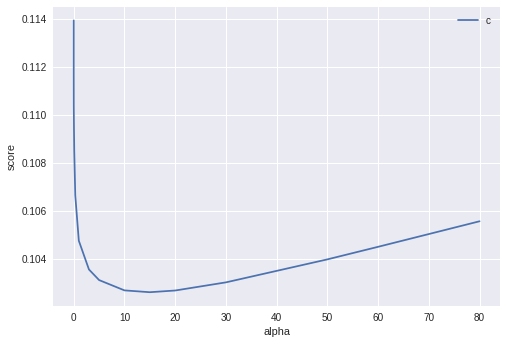

In [63]:
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
ridge_score_table

In [64]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds)).fit(X, y)

cv_rmse(ridge_model2).mean()

0.10263463637922936

In [65]:
ridge_model2.steps[1][1].alpha_

14.6

### 套索回归 Lasso Regression (L1 penalty)

In [66]:
from sklearn.linear_model import LassoCV


alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(X, y)

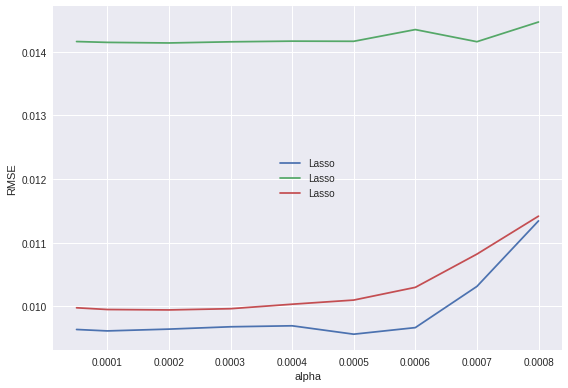

In [67]:
scores = lasso_model2.steps[1][1].mse_path_

plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [68]:
lasso_model2.steps[1][1].alpha_

0.0007

In [69]:
cv_rmse(lasso_model2).mean()

0.10299719809943142

In [70]:
coeffs = pd.DataFrame(list(zip(X.columns, lasso_model2.steps[1][1].coef_)), columns=['Predictors', 'Coefficients'])

In [71]:
used_coeffs = coeffs[coeffs['Coefficients'] != 0].sort_values(by='Coefficients', ascending=False)
print(used_coeffs.shape)
print(used_coeffs)

(92, 2)
                Predictors  Coefficients
2              OverallQual      0.112749
35       Total_sqr_footage      0.100129
4                YearBuilt      0.096562
87    Neighborhood_Crawfor      0.086172
14               GrLivArea      0.080195
11                1stFlrSF      0.077902
152    Exterior1st_BrkFace      0.070110
10             TotalBsmtSF      0.066959
256         Functional_Typ      0.061497
103   Neighborhood_StoneBr      0.061188
102   Neighborhood_Somerst      0.057608
246         KitchenQual_Ex      0.052983
199            BsmtQual_Ex      0.049353
309           SaleType_New      0.046735
3              OverallCond      0.044895
210        BsmtExposure_Gd      0.038525
108        Condition1_Norm      0.038279
84    Neighborhood_BrkSide      0.035301
60             MSZoning_RL      0.034477
1                  LotArea      0.032123
195       Foundation_PConc      0.025664
5             YearRemodAdd      0.025349
97    Neighborhood_NridgHt      0.024946
24      

In [72]:
used_coeffs_values = X[used_coeffs['Predictors']]
used_coeffs_values.shape

(1453, 92)

In [73]:
overfit_test2 = []
for i in used_coeffs_values.columns:
    counts2 = used_coeffs_values[i].value_counts()
    zeros2 = counts2.iloc[0]
    if zeros2 / len(used_coeffs_values) * 100 > 99.5:
        overfit_test2.append(i)
        
overfit_test2

['PoolArea']

### 弹性网 Elastic Net (L1 and L2 penalty)

In [74]:
from sklearn.linear_model import ElasticNetCV

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(X, y)

In [75]:
cv_rmse(elastic_model3).mean()

0.10268011048215894

In [76]:
print(elastic_model3.steps[1][1].l1_ratio_)
print(elastic_model3.steps[1][1].alpha_)

0.9
0.0002


### Xgboost
试试能不能提高分数

In [77]:
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor

以下函数用来获得最佳boosting回合。通过使用xgb.cv的早停法完成。

In [78]:
from sklearn.metrics import mean_squared_error

def modelfit(alg, dtrain, target, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, 
                              label=y.values)
        
        print("\nGetting Cross-validation result..")
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #将算法fit在数据上:
    print("\nFitting algorithm to data...")
    alg.fit(dtrain, target, eval_metric='rmse')
        
    #预测训练集:
    print("\nPredicting from training data...")
    dtrain_predictions = alg.predict(dtrain)
        
    #打印模型结果:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(mean_squared_error(target.values,
                                             dtrain_predictions)))



通过网格搜索得到XGBoost优化后的参数

In [79]:
xgb3 = XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(X, y)

### 支持向量回归 Support Vector Regression
实验证明效果不好,所以后面的模型融合就没用上.

网格搜索得到SVR的C和gammade的最优值

In [80]:
from sklearn import svm
svr_opt = svm.SVR(C = 100000, gamma = 1e-08)

svr_fit = svr_opt.fit(X, y)

### LightGBM

In [81]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [82]:
cv_rmse(lgbm_model).mean()

0.1077964107144671

In [83]:
lgbm_fit = lgbm_model.fit(X, y)

## 融合方法 Ensemble methods
试试用融合模型的方法在测试数据上是否能取得更好的性能。 为了保持练习的约束，将三种模型结合起来。

- 交叉验证的套索模型 LassoCV
- 交叉验证的岭模型 RidgeCV
- 弹性网 Elasticnet

由于本地RMSE和kaggle RMSLE不一样，实验平均花费很多时间。 基本上我正在优化过拟合和欠拟合之间的折衷。

首先，我将通过一个称为堆叠泛化的过程来构建一个元回归器，该过程在训练集的一部分上训练一个模型（它首先被分割成一个新的训练集和一个保留集）。 然后，算法在保留集上测试这些模型，并将这些预测（称为“折叠预测”）用作“元模型”的输入。 以下是该过程的图示。

In [84]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url = "http://i.imgur.com/QBuDOjs.jpg")

### 融合1- 堆叠泛化 Ensemble 1 - Stacking Generalization
堆叠泛化，尝试了几个不同的选项, python的Vecstack包好像有点问题，所以用mlxtend包。

In [85]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#设置模型
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11))

xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.01, n_estimators=3460, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))


#堆叠
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgboost, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)

#准备dataframes
stackX = np.array(X)
stacky = np.array(y)

In [86]:
#打分

print("cross validated scores")

for model, label in zip([ridge, lasso, elasticnet, xgboost, lightgbm, stack_gen],
                     ['RidgeCV', 'LassoCV', 'ElasticNetCV', 'xgboost', 'lightgbm',
                      'StackingCVRegressor']):
    
    SG_scores = cross_val_score(model, stackX, stacky, cv=kfolds,
                               scoring='neg_mean_squared_error')
    print("RMSE", np.sqrt(-SG_scores.mean()), "SD", scores.std(), label)

cross validated scores
RMSE 0.10337176442850228 SD 0.0019936895097974255 RidgeCV
RMSE 0.10330609893117793 SD 0.0019936895097974255 LassoCV
RMSE 0.10339960384654641 SD 0.0019936895097974255 ElasticNetCV
RMSE 0.10750123140572149 SD 0.0019936895097974255 xgboost
RMSE 0.10913277667077372 SD 0.0019936895097974255 lightgbm
RMSE 0.10560930266201665 SD 0.0019936895097974255 StackingCVRegressor


In [87]:
stack_gen_model = stack_gen.fit(stackX, stacky)

### 混合2 Ensemble 2 - averaging
我的本地分数与我真正的kaggle分数完全分离。最后我觉得SVR并没有帮助我的分数，所以它不包含在我的最终预测中。

In [88]:
em_preds = elastic_model3.predict(testing_features)
lasso_preds = lasso_model2.predict(testing_features)
ridge_preds = ridge_model2.predict(testing_features)
stack_gen_preds = stack_gen_model.predict(testing_features)
xgb_preds = xgb_fit.predict(testing_features)
svr_preds = svr_fit.predict(testing_features)
lgbm_preds = lgbm_fit.predict(testing_features)

In [89]:
stack_preds = ((0.2*em_preds) + (0.1*lasso_preds) + (0.1*ridge_preds) + 
               (0.2*xgb_preds) + (0.1*lgbm_preds) + (0.3*stack_gen_preds))

In [ ]:
print(stack_preds)

## 提交预测
实际提交要做指数变化回到正常值,因为训练的是logSalePrice

In [ ]:
submission = pd.read_csv("../input/sample_submission.csv")

In [ ]:
submission.to_csv("final_submission.csv", index=False)

In [ ]:
submission.iloc[:,1] = np.expm1(stack_preds)

# 回顾

kaggle 排名

![](./kaggle_ranking.png)

试过
- Lasso Regression
- Elatic Net Regression 
- Ridge Regression 
- XGBoost 
- LightGBM
- SVM(效果不好,最后ensemble的时候没用) 
- 甚至是Gradient Boosting Regression(删了,不在上面)
#### 发现调模型的权重固然有影响,但是前面特征工程选择处理方面是拉开差距的地方,因此参考了大牛们的办法,建了特征###

#### 融合模型能在单一基准模型的基准上有不小的提升

#### skew 比较高级,以前没接触过,666